# 파일 디렉토리 생성 

In [95]:
for i in range(0, 20) : 
    os.mkdir(f'/Users/kibeomkim/Desktop/flickr/train/{i}')

In [96]:
for i in range(0, 20) : 
    os.mkdir(f'/Users/kibeomkim/Desktop/flickr/test/{i}')

# 데이터 분류해서 저장 

In [126]:
import os
import shutil

total_image_list = os.listdir('/Users/kibeomkim/Documents/GitHub/tensorflow-finetune-flickr-style/images')
train_image_list = open('/Users/kibeomkim/Documents/GitHub/tensorflow-finetune-flickr-style/train.txt', 'r').readlines()
test_image_list = open('/Users/kibeomkim/Documents/GitHub/tensorflow-finetune-flickr-style/test.txt', 'r').readlines()

train_image_list = [name.split()[0].split('/')[-1] for name in train_image_list]
test_image_list = [name.split()[0].split('/')[-1] for name in test_image_list]

for image_file in total_image_list : 
    if (image_file in train_image_list) : 
        label = image_file.split('_')[-1].split('.')[0] # 레이블
        shutil.copyfile(f'/Users/kibeomkim/Documents/GitHub/tensorflow-finetune-flickr-style/images/{image_file}', f'/Users/kibeomkim/Desktop/flickr/train/{label}/{image_file}') # 복사 
    else : # 테스트 file 이면 
        label = image_file.split('_')[-1].split('.')[0] # 레이블
        shutil.copyfile(f'/Users/kibeomkim/Documents/GitHub/tensorflow-finetune-flickr-style/images/{image_file}', f'/Users/kibeomkim/Desktop/flickr/test/{label}/{image_file}') # 복사 

# Flickr style model 

In [1]:
# 이미지 데이터 전처리 # 데이터 증식 사용

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255) # 검증데이터는 증식하지 않는다.

train_generator = train_datagen.flow_from_directory(
    '/Users/kibeomkim/Desktop/flickr/train', 
    target_size=(150, 150),
    batch_size=20, 
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    '/Users/kibeomkim/Desktop/flickr/test',
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical'
)

Found 7993 images belonging to 20 classes.
Found 1999 images belonging to 20 classes.


In [2]:
# VGG16 합성곱 기반 층 만들기 

from keras.applications import vgg16

# 합성곱 기반 층
conv_base = vgg16.VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150, 150, 3)
)

2022-02-14 18:39:47.241866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-14 18:39:47.241989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [3]:
# 데이터 증식 사용해서 특성 추출 후 분류 
# 엔드 투 엔드로 진행 

from keras import models 
from keras import layers 

# 모델 정의
model = models.Sequential() 
model.add(conv_base)# 합성곱 기반 층
model.add(layers.Flatten()) # 합성곱 기반 층 출력 1차원 텐서(벡터로)변형
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))

In [4]:
# 합성곱 기반 층 가중치 동결 
conv_base.trainable = False
print(f'{len(model.trainable_weights)}') # 분류기의 가중치 4개 빼고 동결되었다. 

4


In [6]:
from keras import optimizers

# 모델 컴파일 
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.rmsprop_v2.RMSprop(lr=2e-5),
    metrics=['acc']
)

# 모델 훈련 

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100, 
    epochs=30,
    validation_data = validation_generator, 
    validation_steps=50, 
    verbose=2
)

2022-02-14 16:58:18.796132: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-02-14 16:58:19.006965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-14 16:58:37.076594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 - 26s - loss: 2.9781 - acc: 0.0935 - val_loss: 2.8774 - val_acc: 0.1300 - 26s/epoch - 262ms/step
Epoch 2/30
100/100 - 24s - loss: 2.8087 - acc: 0.1480 - val_loss: 2.7636 - val_acc: 0.1760 - 24s/epoch - 240ms/step
Epoch 3/30
100/100 - 24s - loss: 2.7037 - acc: 0.2070 - val_loss: 2.6427 - val_acc: 0.2000 - 24s/epoch - 239ms/step
Epoch 4/30
100/100 - 25s - loss: 2.6126 - acc: 0.2210 - val_loss: 2.5961 - val_acc: 0.2370 - 25s/epoch - 251ms/step
Epoch 5/30
100/100 - 24s - loss: 2.5674 - acc: 0.2480 - val_loss: 2.5546 - val_acc: 0.2460 - 24s/epoch - 243ms/step
Epoch 6/30
100/100 - 24s - loss: 2.4914 - acc: 0.2555 - val_loss: 2.4849 - val_acc: 0.2620 - 24s/epoch - 238ms/step
Epoch 7/30
100/100 - 24s - loss: 2.4453 - acc: 0.2770 - val_loss: 2.4285 - val_acc: 0.2750 - 24s/epoch - 238ms/step
Epoch 8/30
100/100 - 24s - loss: 2.3933 - acc: 0.2865 - val_loss: 2.4309 - val_acc: 0.2620 - 24s/epoch - 238ms/step
Epoch 9/30
100/100 - 24s - loss: 2.3615 - acc: 0.3155 - val_loss: 2.3853 - val_acc:

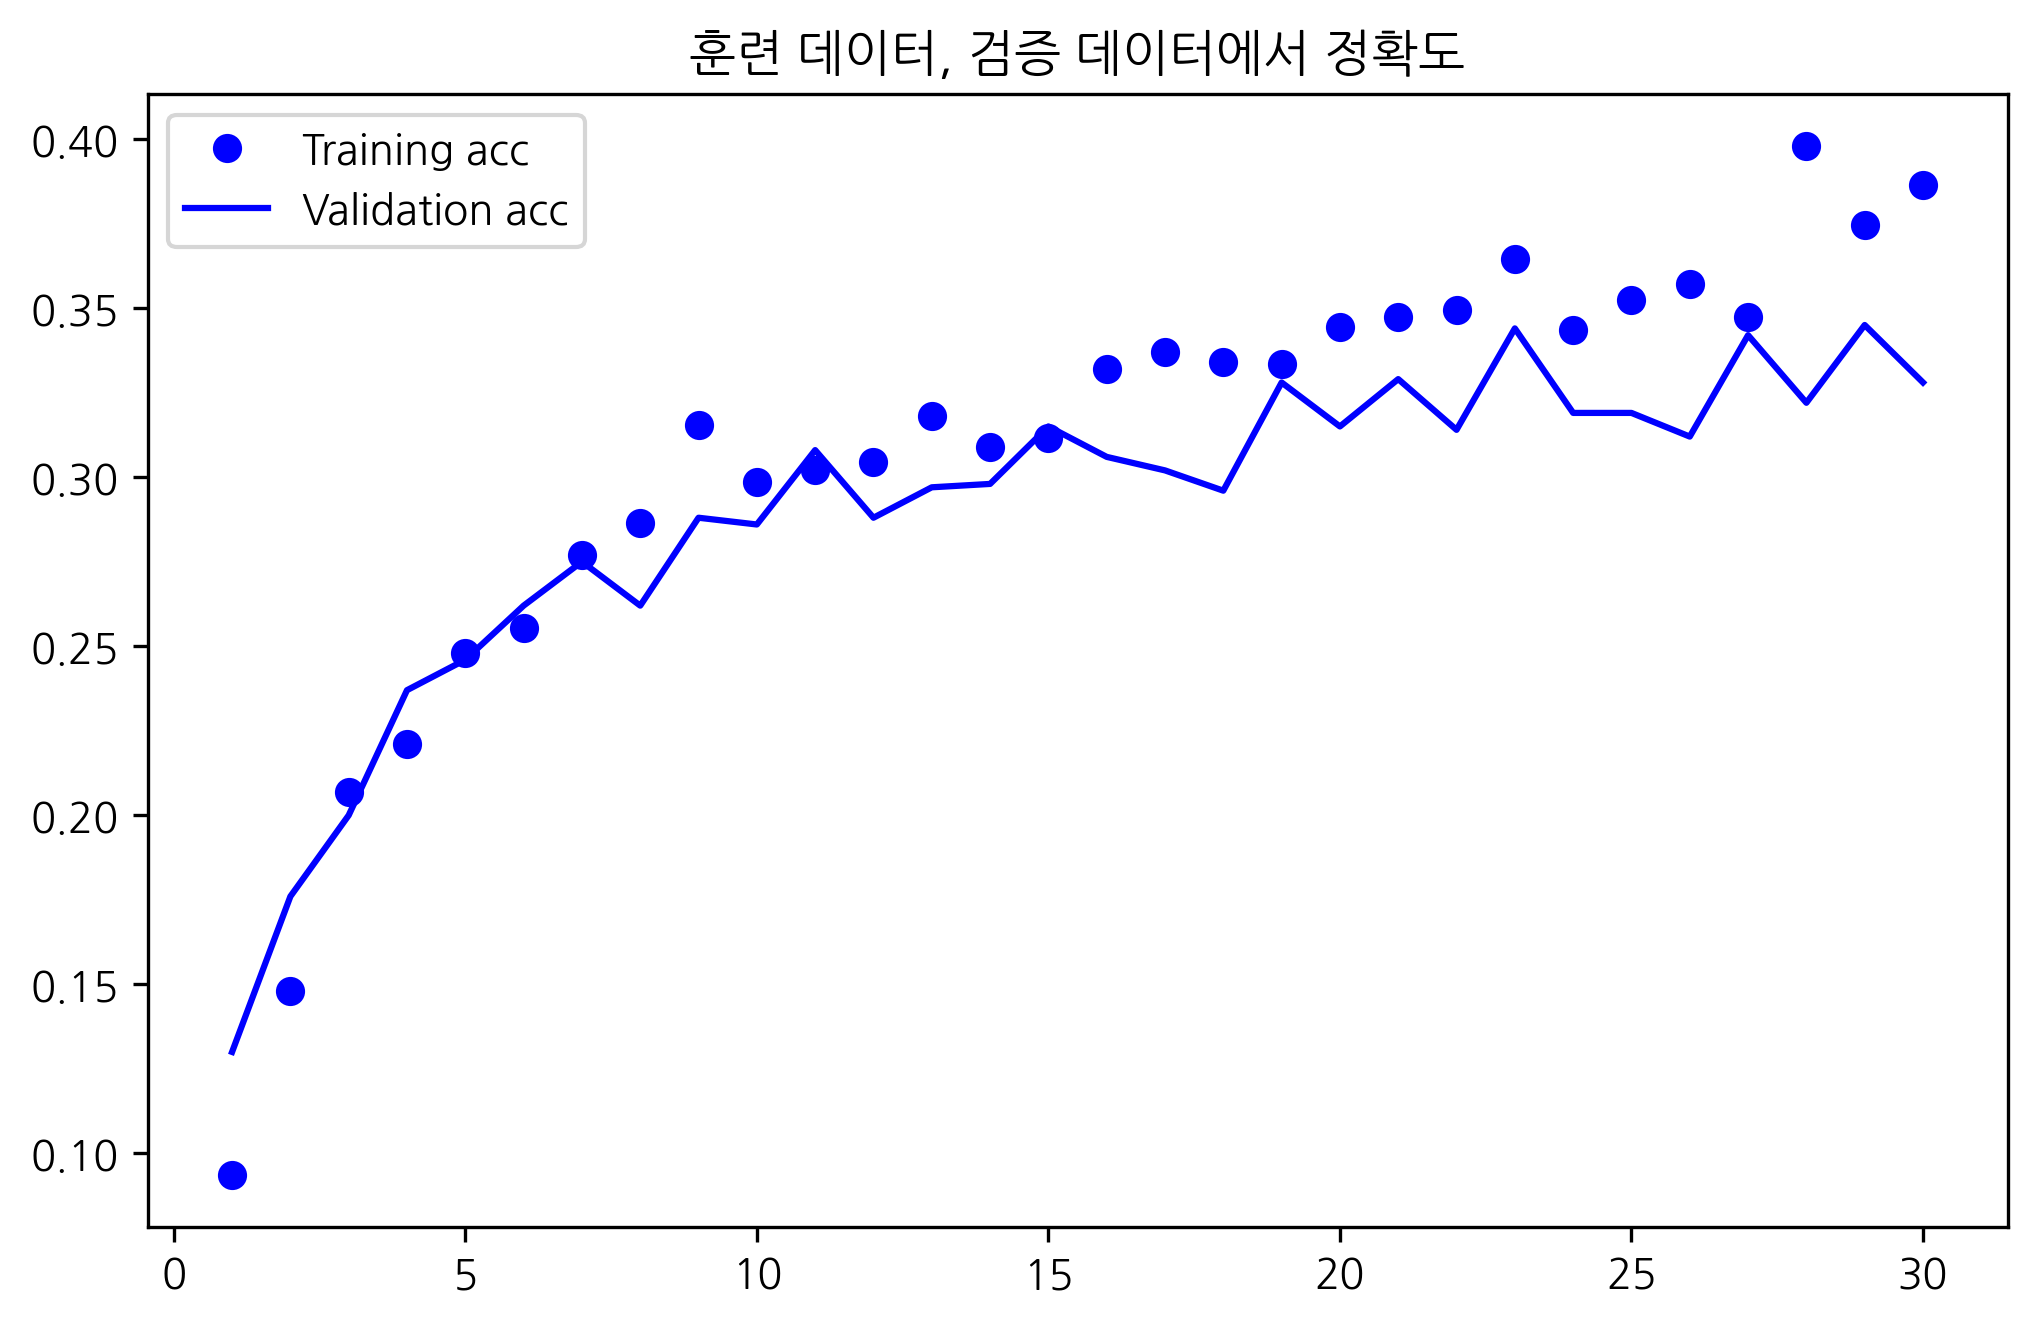

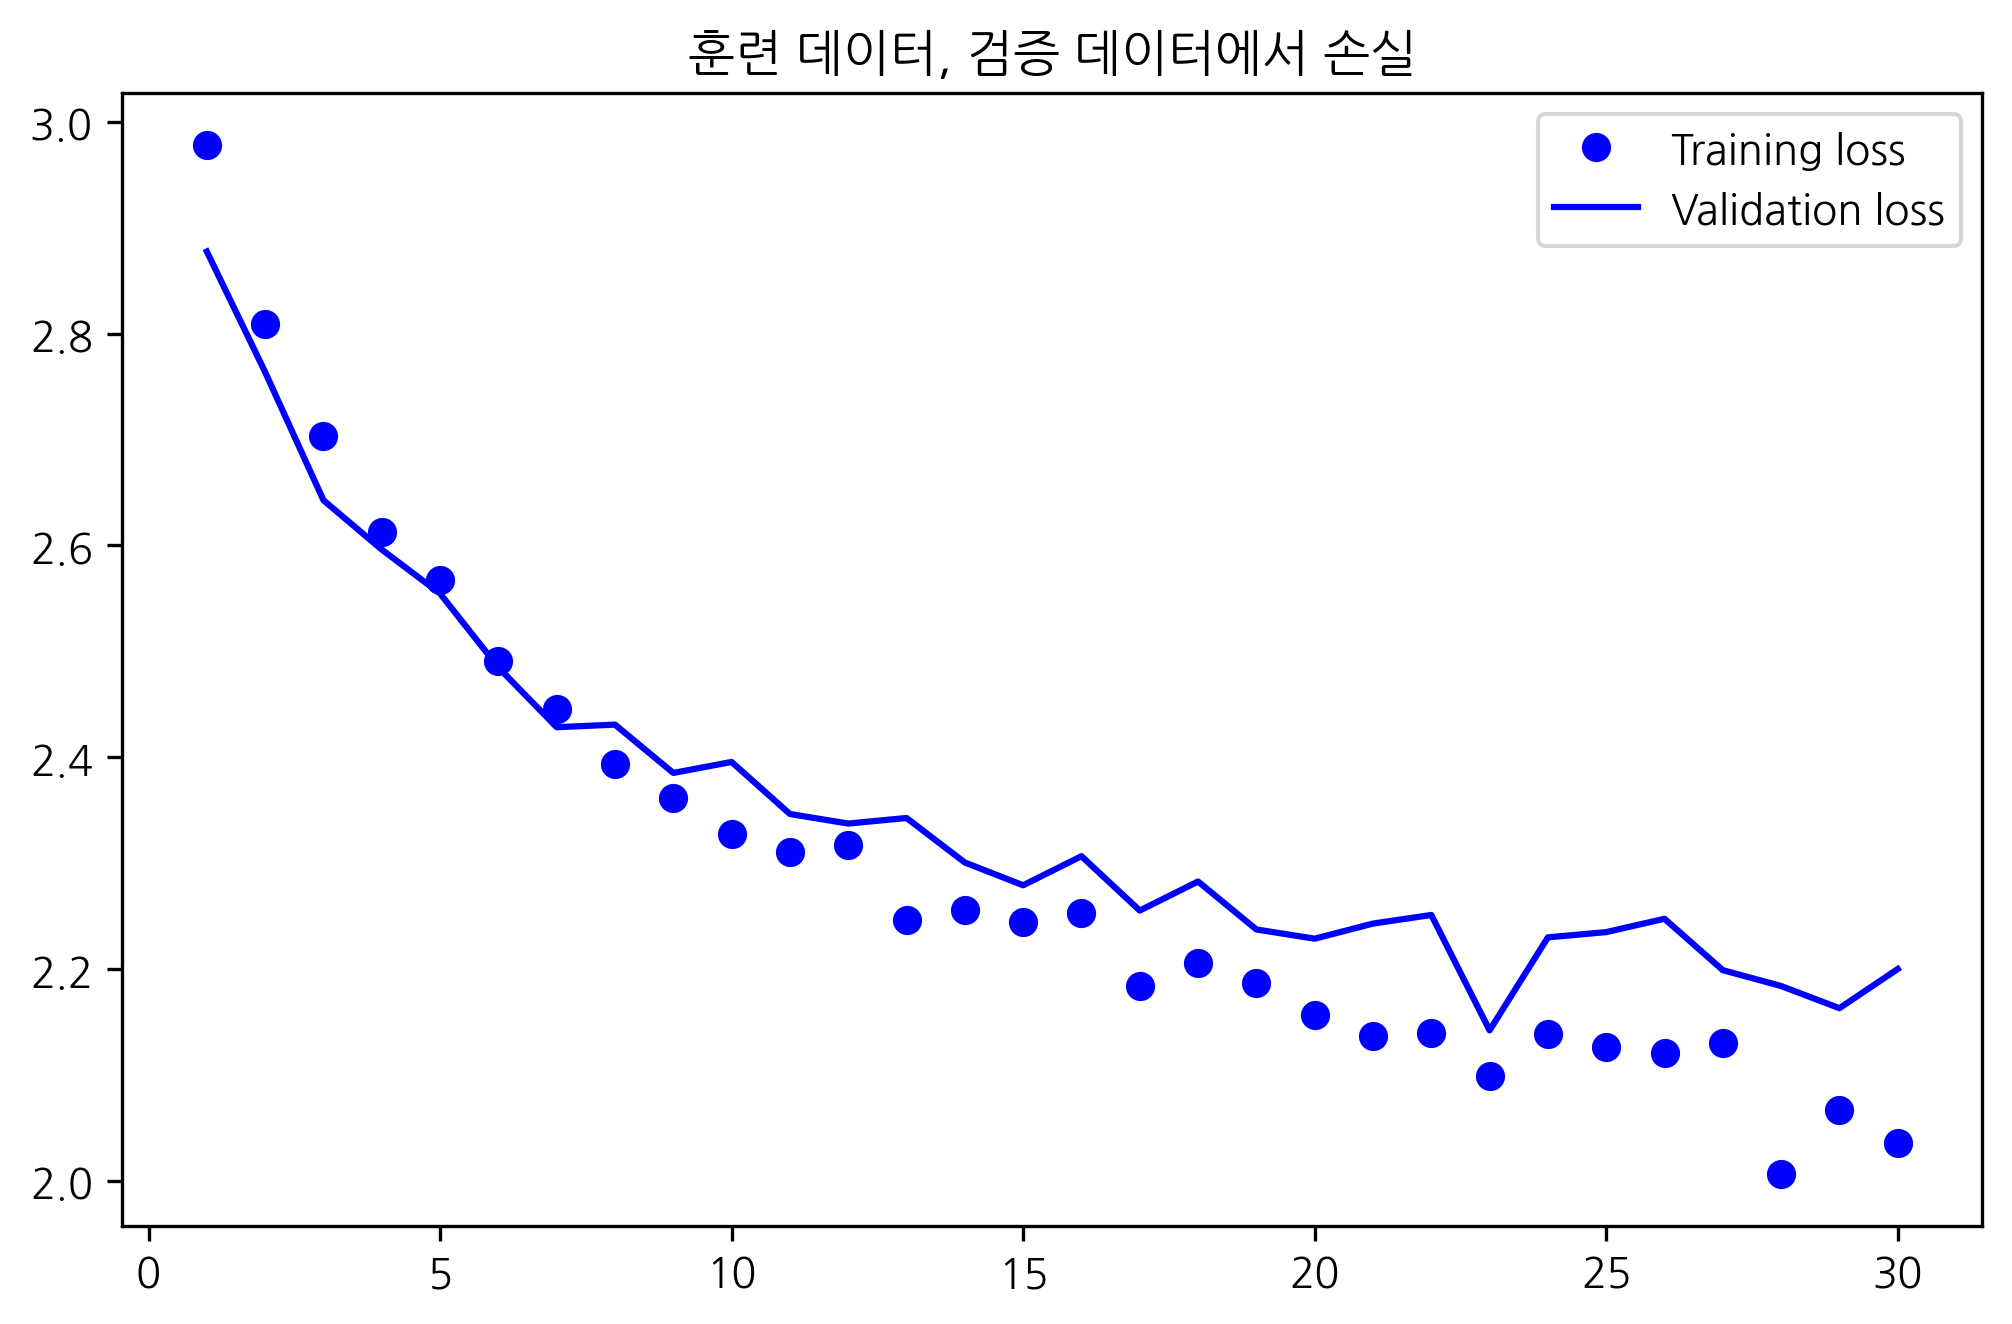

In [7]:
# 결과 시각화 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title(f'훈련 데이터, 검증 데이터에서 정확도')
plt.legend()

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title(f'훈련 데이터, 검증 데이터에서 손실')
plt.legend()

plt.show()

In [3]:
# epoch = 50으로 증가 

from keras import models 
from keras import layers 
from keras import optimizers

# 모델 정의
model = models.Sequential() 
model.add(conv_base)# 합성곱 기반 층
model.add(layers.Flatten()) # 합성곱 기반 층 출력 1차원 텐서(벡터로)변형
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))

# 합성곱 기반 층 가중치 동결 
conv_base.trainable = False
print(f'{len(model.trainable_weights)}') # 분류기의 가중치 4개 빼고 동결되었다. 

# 모델 컴파일 
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.rmsprop_v2.RMSprop(lr=3e-5), # 분류기 가중치 학습률도 조금 더 올려보자. 
    metrics=['acc']
)

# 모델 훈련 

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100, 
    epochs=50,
    validation_data = validation_generator, 
    validation_steps=50, 
    verbose=2
)

4
Epoch 1/50


2022-02-14 18:40:30.869379: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-14 18:40:31.067690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-14 18:40:48.066498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 - 25s - loss: 2.9476 - acc: 0.1070 - val_loss: 2.8469 - val_acc: 0.1570 - 25s/epoch - 250ms/step
Epoch 2/50
100/100 - 24s - loss: 2.7696 - acc: 0.1610 - val_loss: 2.7114 - val_acc: 0.2020 - 24s/epoch - 240ms/step
Epoch 3/50
100/100 - 24s - loss: 2.6312 - acc: 0.2200 - val_loss: 2.5807 - val_acc: 0.2440 - 24s/epoch - 240ms/step
Epoch 4/50
100/100 - 24s - loss: 2.5087 - acc: 0.2640 - val_loss: 2.5183 - val_acc: 0.2460 - 24s/epoch - 241ms/step
Epoch 5/50
100/100 - 24s - loss: 2.4958 - acc: 0.2700 - val_loss: 2.4737 - val_acc: 0.2450 - 24s/epoch - 241ms/step
Epoch 6/50
100/100 - 24s - loss: 2.4358 - acc: 0.2670 - val_loss: 2.3912 - val_acc: 0.2900 - 24s/epoch - 238ms/step
Epoch 7/50
100/100 - 24s - loss: 2.3834 - acc: 0.2755 - val_loss: 2.3825 - val_acc: 0.2880 - 24s/epoch - 237ms/step
Epoch 8/50
100/100 - 24s - loss: 2.3490 - acc: 0.2940 - val_loss: 2.3346 - val_acc: 0.3120 - 24s/epoch - 237ms/step
Epoch 9/50
100/100 - 24s - loss: 2.3253 - acc: 0.2945 - val_loss: 2.3237 - val_acc:

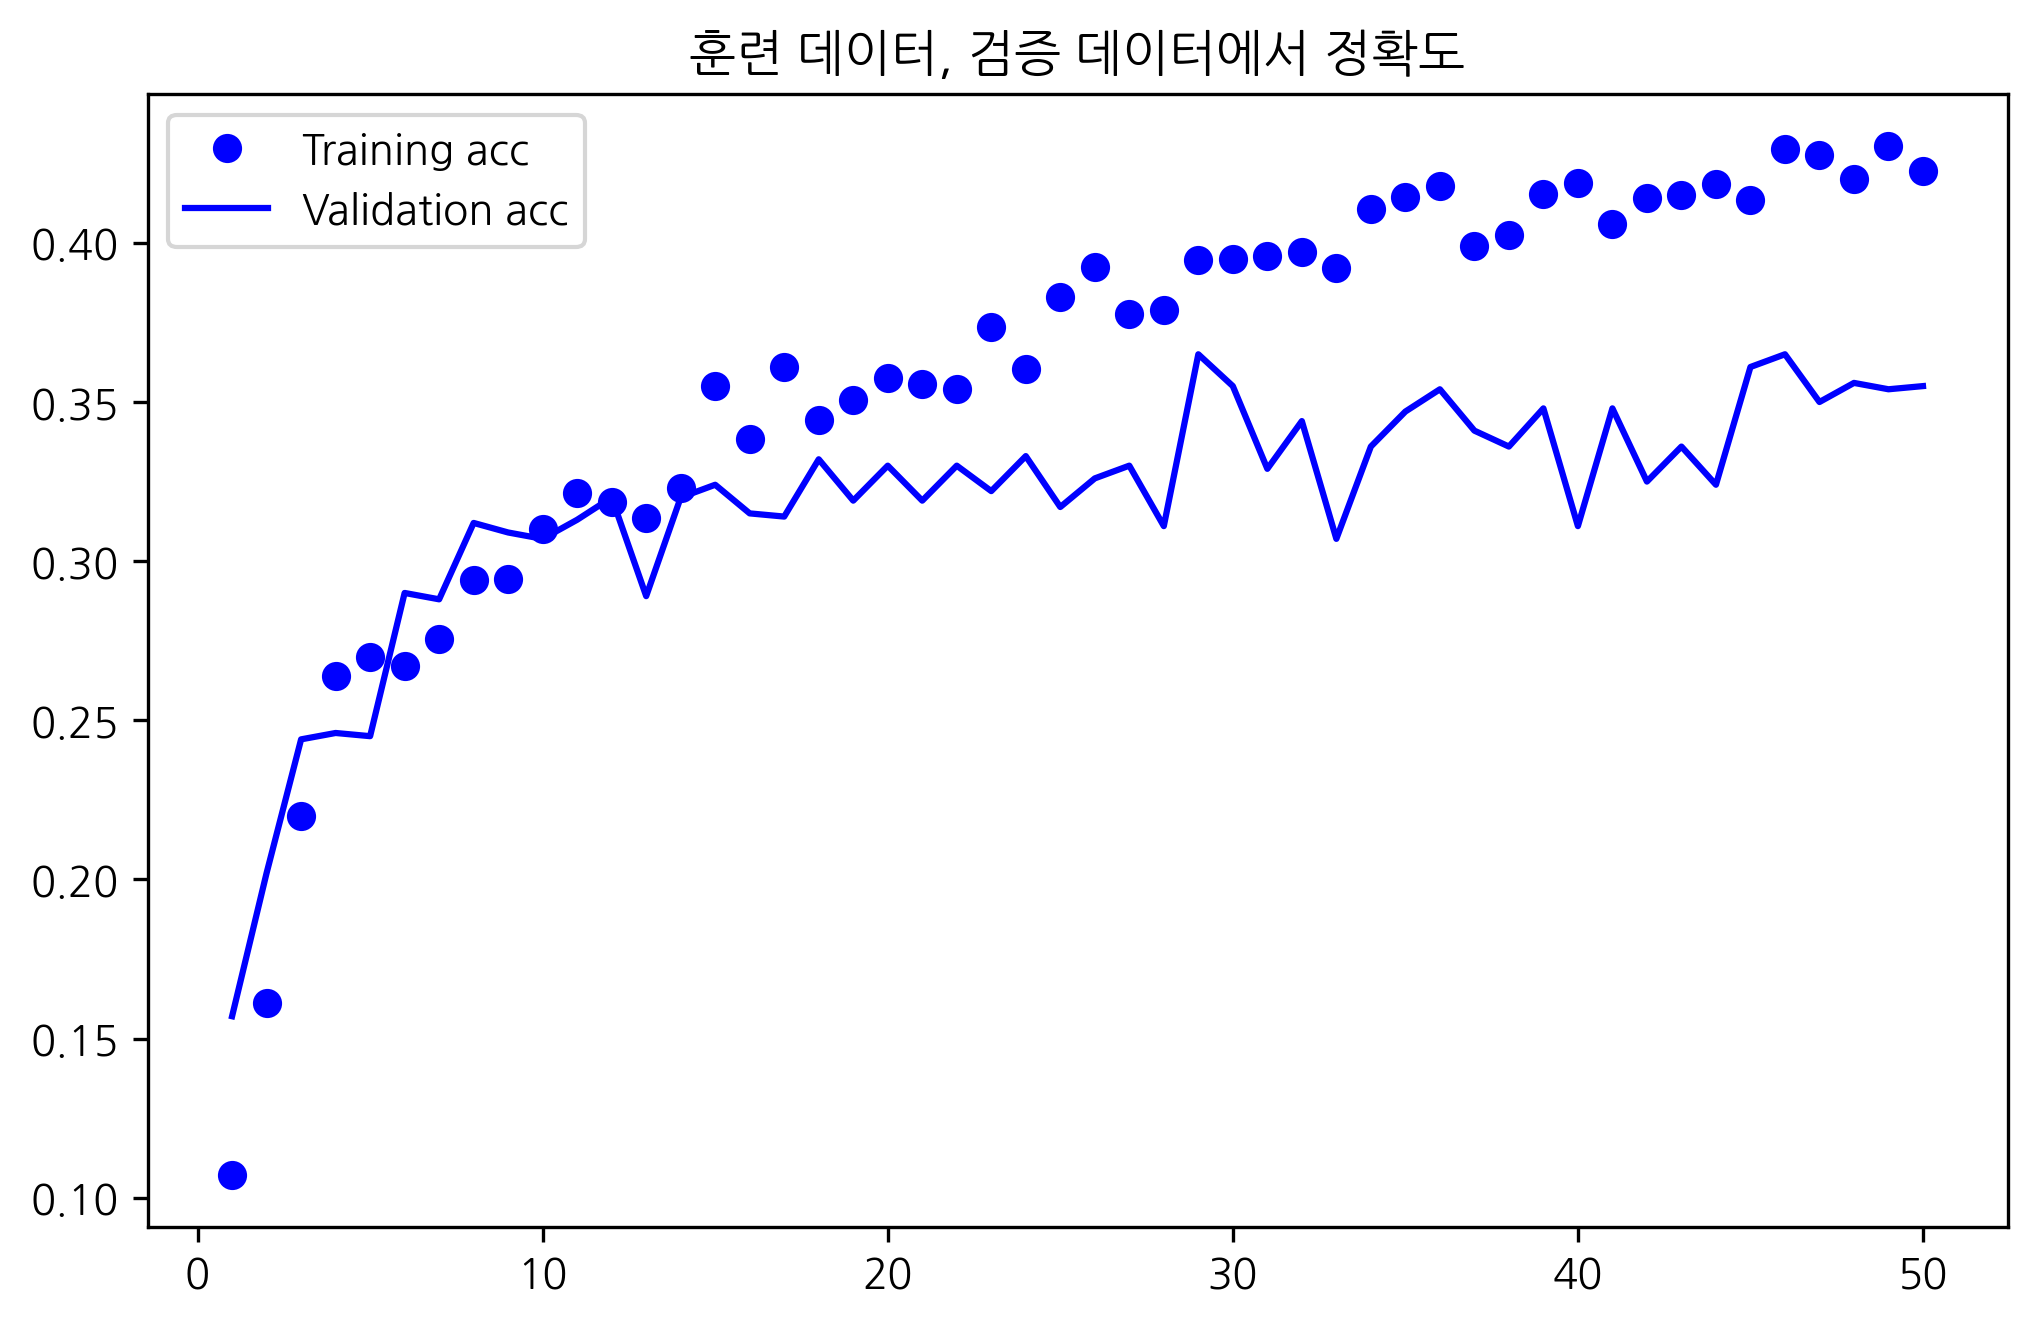

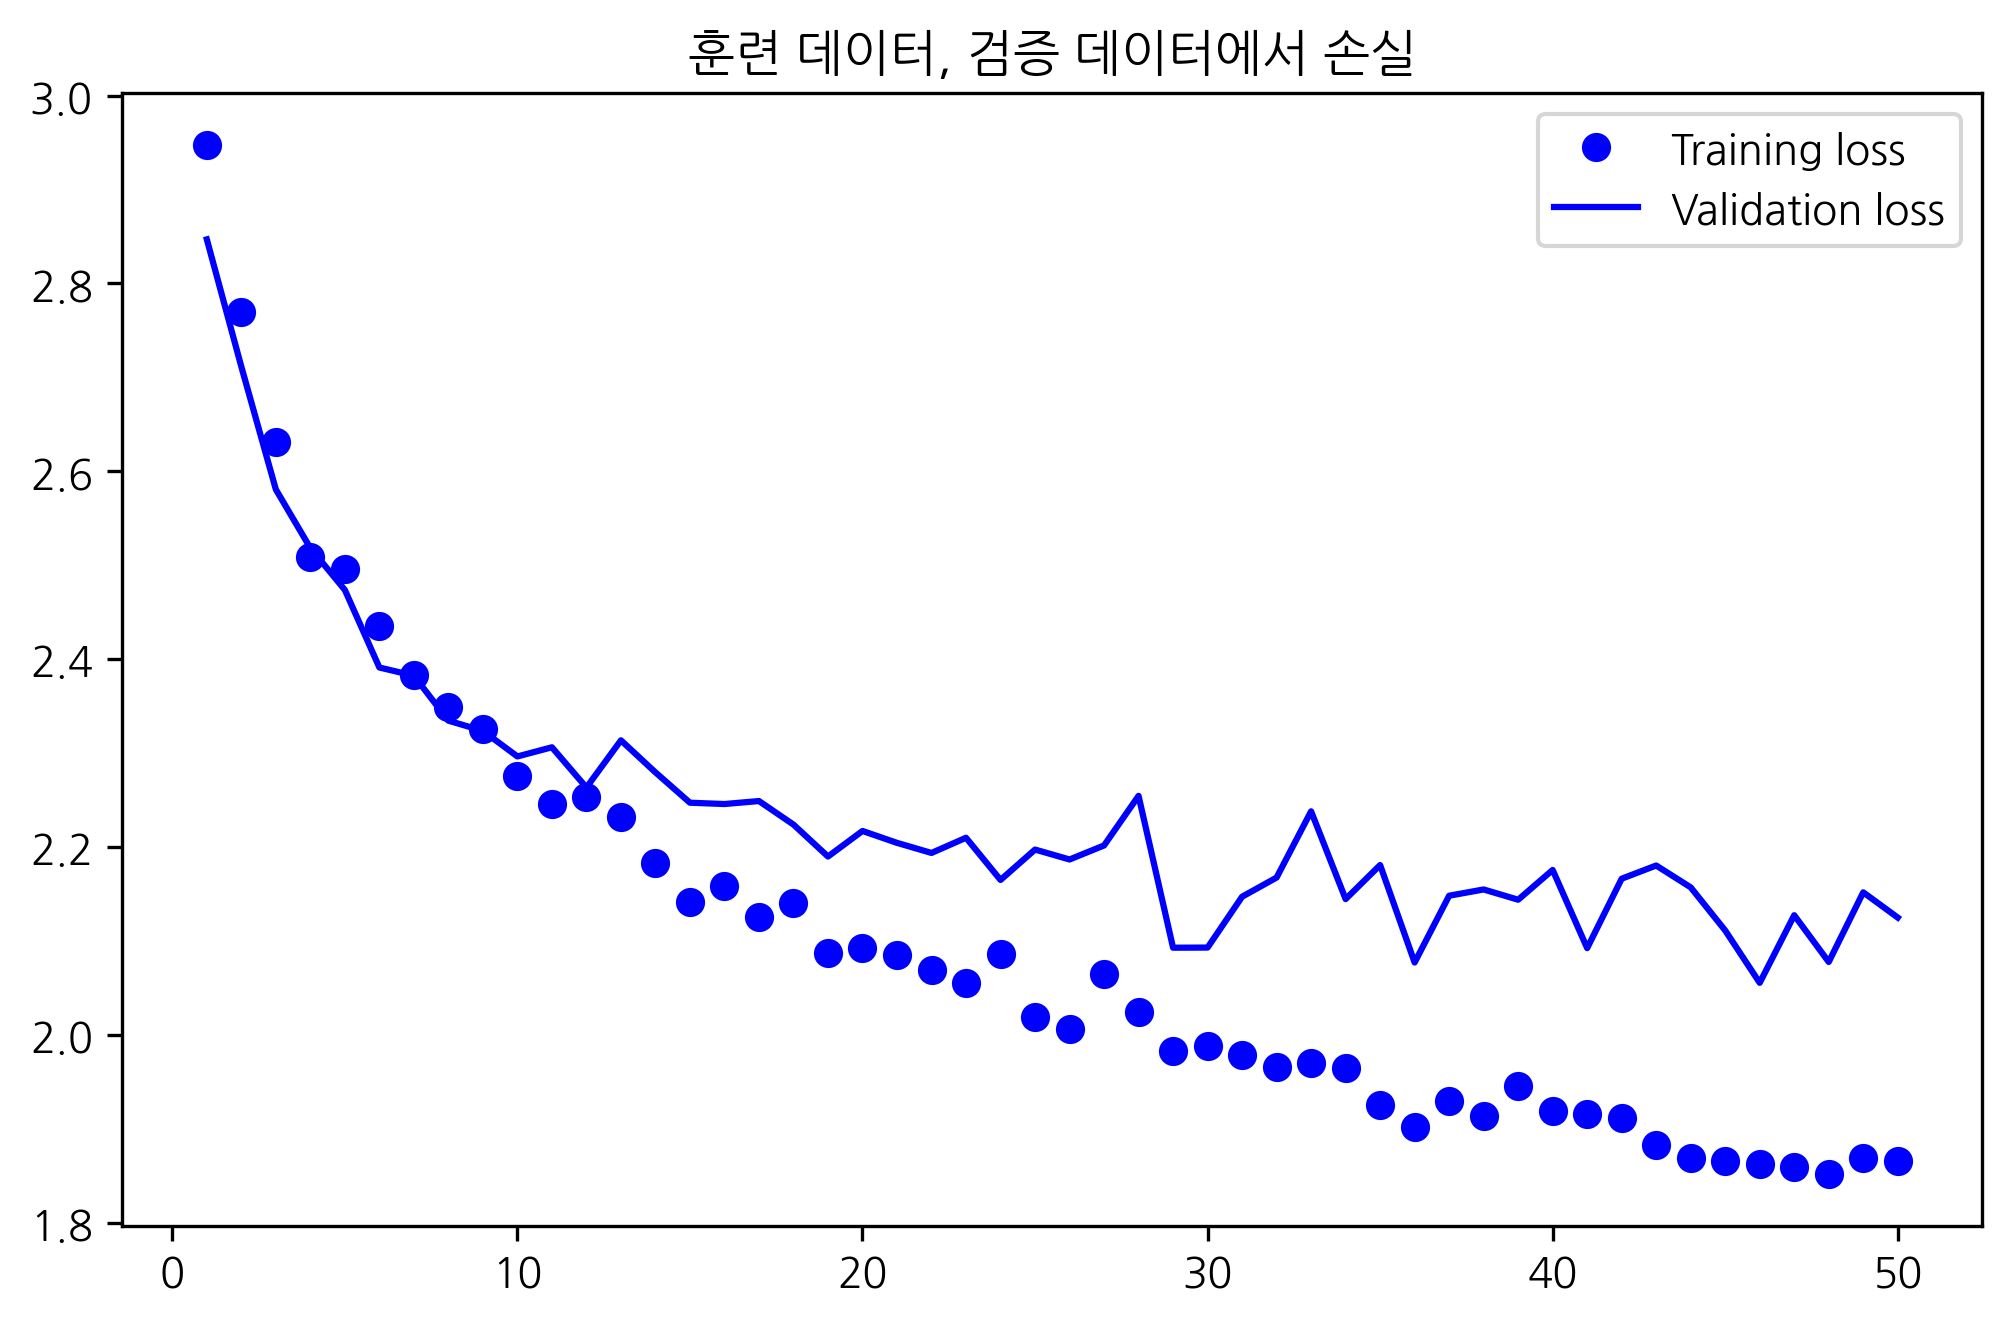

In [4]:
# 결과 시각화 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title(f'훈련 데이터, 검증 데이터에서 정확도')
plt.legend()

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title(f'훈련 데이터, 검증 데이터에서 손실')
plt.legend()

plt.show()

# 미세조정 

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [10]:
# 상위층 동결 해제 (block4-block5)
conv_base.trainable = True 

set_trainable = False 
for layer in conv_base.layers : 
    if layer.name == 'block4_conv1' : 
        set_trainable = True 
    if set_trainable : 
        layer.trainable = True 
    else : 
        layer.trainable = False 

In [15]:
# 미세조정 

# 컴파일
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.rmsprop_v2.RMSprop(lr=1e-6), # 학습률 낮춘다.
    metrics = ['acc']
)
# 훈련
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, 
    epochs=100, 
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Epoch 1/100


2022-02-14 20:24:01.710704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-14 20:24:32.094506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 - 38s - loss: 0.5135 - acc: 0.8580 - val_loss: 2.6633 - val_acc: 0.3860 - 38s/epoch - 385ms/step
Epoch 2/100
100/100 - 38s - loss: 0.4768 - acc: 0.8585 - val_loss: 2.6330 - val_acc: 0.3870 - 38s/epoch - 381ms/step
Epoch 3/100
100/100 - 38s - loss: 0.4903 - acc: 0.8580 - val_loss: 2.6200 - val_acc: 0.3820 - 38s/epoch - 378ms/step
Epoch 4/100
100/100 - 38s - loss: 0.4684 - acc: 0.8590 - val_loss: 2.7781 - val_acc: 0.3640 - 38s/epoch - 381ms/step
Epoch 5/100
100/100 - 39s - loss: 0.4701 - acc: 0.8495 - val_loss: 2.7982 - val_acc: 0.3670 - 39s/epoch - 388ms/step
Epoch 6/100
100/100 - 38s - loss: 0.4809 - acc: 0.8620 - val_loss: 2.7865 - val_acc: 0.3860 - 38s/epoch - 380ms/step
Epoch 7/100
100/100 - 38s - loss: 0.4471 - acc: 0.8685 - val_loss: 2.9192 - val_acc: 0.3610 - 38s/epoch - 378ms/step
Epoch 8/100


KeyboardInterrupt: 

In [9]:
# 모델 저장 
model.save('/Users/kibeomkim/Desktop/flickr_style_model.h5')

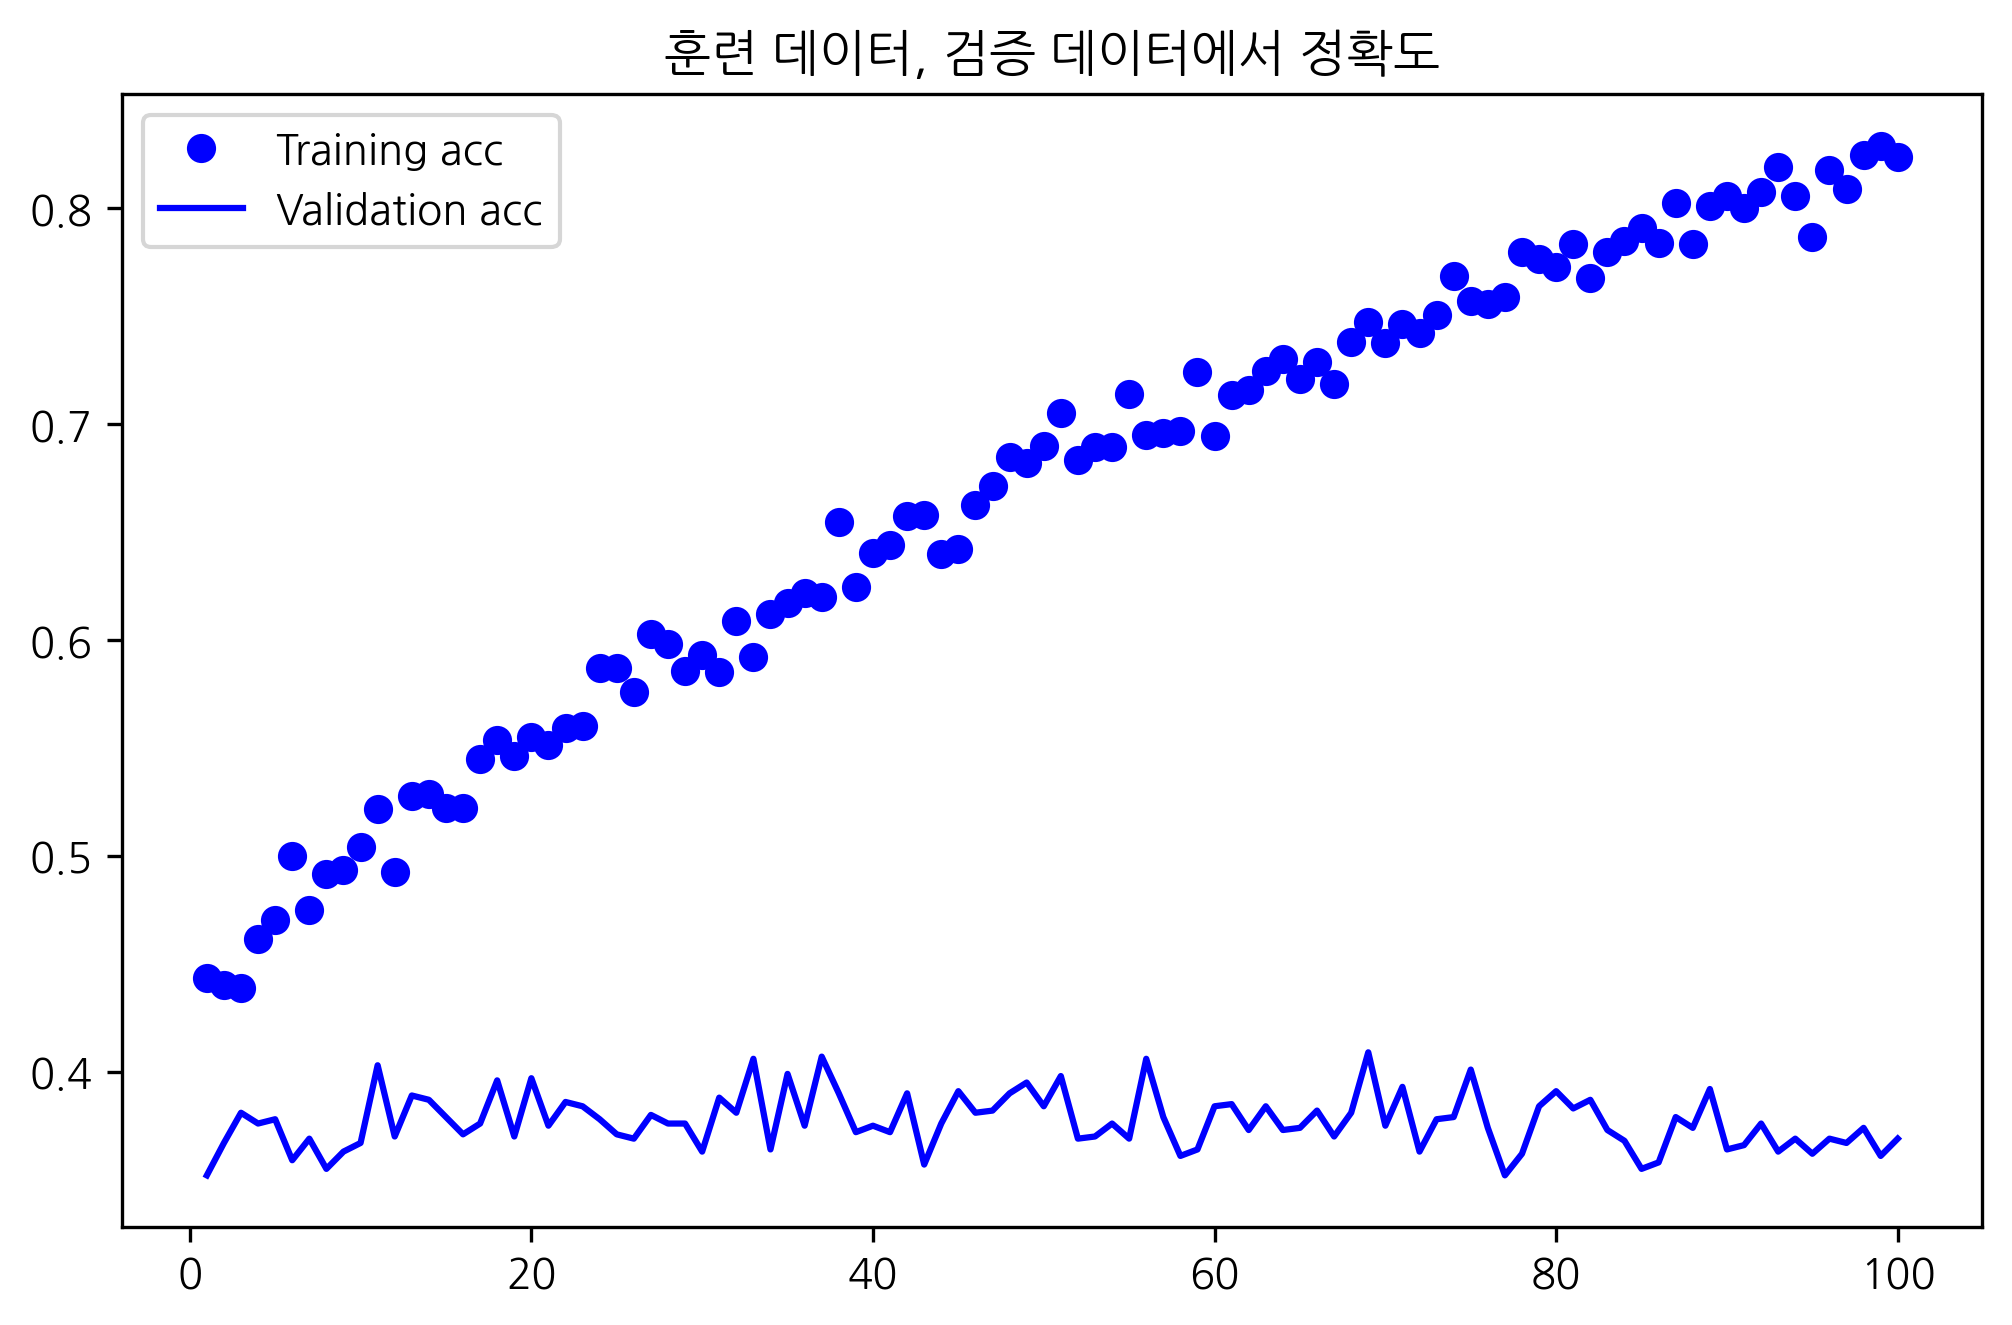

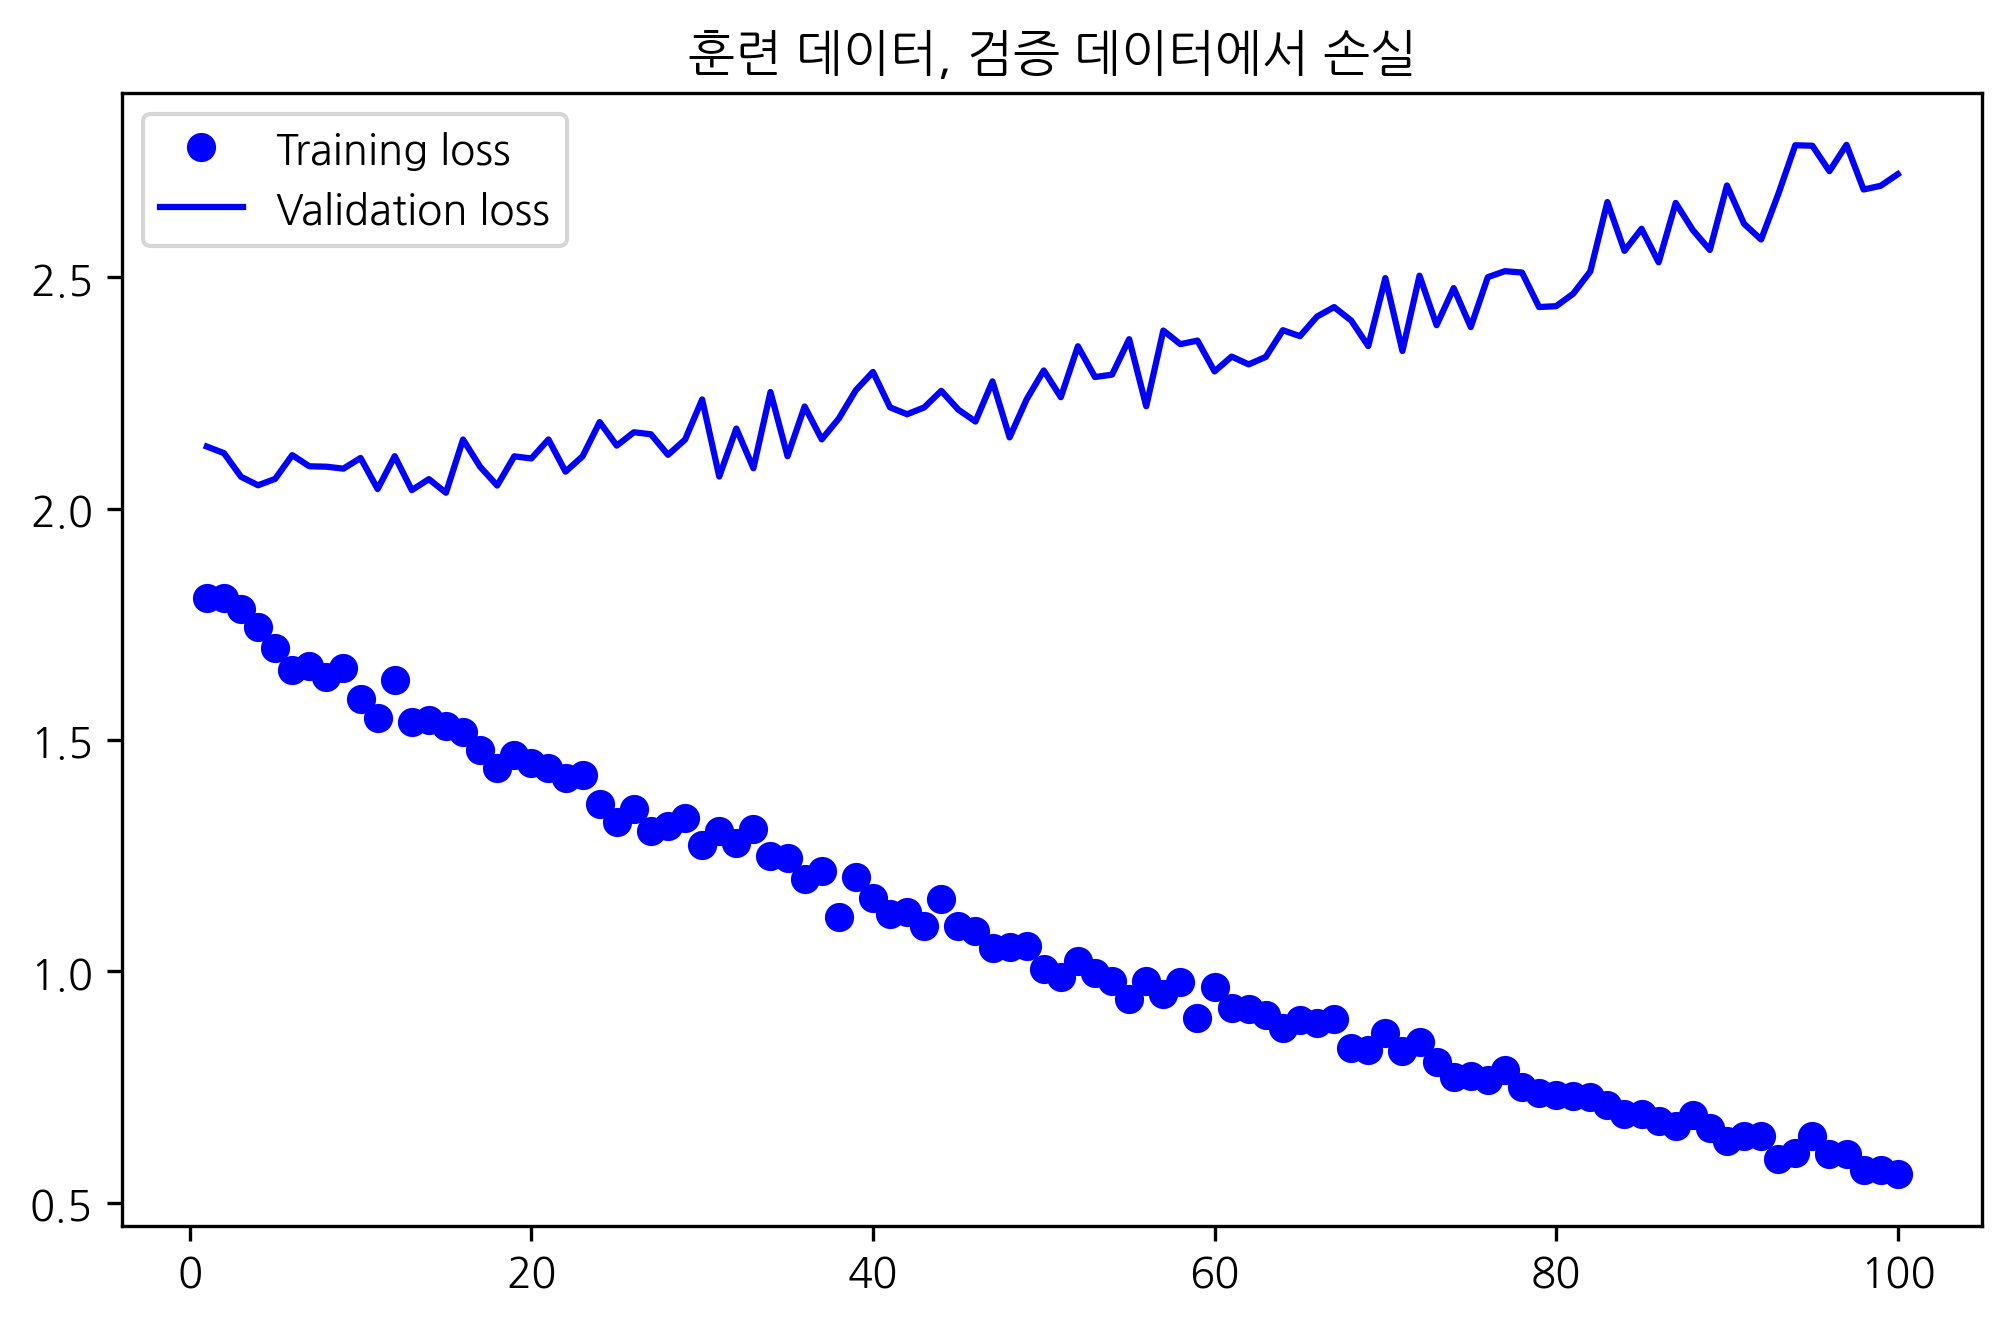

In [7]:
# 결과 시각화 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title(f'훈련 데이터, 검증 데이터에서 정확도')
plt.legend()

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title(f'훈련 데이터, 검증 데이터에서 손실')
plt.legend()

plt.show()

# 다시 모델 세우고 훈련시켜보자. 

In [2]:
# VGG16 합성곱 기반 층 만들기 

from keras.applications import vgg16

# 합성곱 기반 층
conv_base = vgg16.VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150, 150, 3)
)

2022-02-15 00:51:28.812626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-15 00:51:28.812769: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [3]:
from keras import models 
from keras import layers 
from keras import optimizers

# 모델 정의
model = models.Sequential() 
model.add(conv_base)
model.add(layers.Flatten()) 
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2)) # 드롭아웃 층 추가(규제위함)
model.add(layers.Dense(20, activation='softmax'))

# 합성곱 기반 층 가중치 동결 
conv_base.trainable = False
print(f'{len(model.trainable_weights)}') 

# 모델 컴파일 
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.rmsprop_v2.RMSprop(lr=2e-5),
    metrics=['acc']
)

# 모델 훈련 

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100, 
    epochs=500, 
    validation_data = validation_generator, 
    validation_steps=50, 
    verbose=2
)

4
Epoch 1/500


2022-02-15 00:52:09.346372: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-15 00:52:09.552632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-15 00:52:26.664212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 - 25s - loss: 3.0698 - acc: 0.0765 - val_loss: 2.9372 - val_acc: 0.0880 - 25s/epoch - 251ms/step
Epoch 2/500
100/100 - 24s - loss: 2.9300 - acc: 0.1094 - val_loss: 2.8387 - val_acc: 0.1520 - 24s/epoch - 236ms/step
Epoch 3/500
100/100 - 24s - loss: 2.8314 - acc: 0.1335 - val_loss: 2.7696 - val_acc: 0.1780 - 24s/epoch - 241ms/step
Epoch 4/500
100/100 - 24s - loss: 2.7728 - acc: 0.1605 - val_loss: 2.7163 - val_acc: 0.2010 - 24s/epoch - 236ms/step
Epoch 5/500
100/100 - 24s - loss: 2.7343 - acc: 0.1715 - val_loss: 2.6645 - val_acc: 0.2120 - 24s/epoch - 237ms/step
Epoch 6/500
100/100 - 24s - loss: 2.6877 - acc: 0.1955 - val_loss: 2.6353 - val_acc: 0.2180 - 24s/epoch - 236ms/step
Epoch 7/500
100/100 - 24s - loss: 2.6345 - acc: 0.2075 - val_loss: 2.5700 - val_acc: 0.2420 - 24s/epoch - 239ms/step
Epoch 8/500
100/100 - 24s - loss: 2.6015 - acc: 0.2180 - val_loss: 2.5480 - val_acc: 0.2360 - 24s/epoch - 238ms/step
Epoch 9/500
100/100 - 24s - loss: 2.5338 - acc: 0.2428 - val_loss: 2.4915 - 

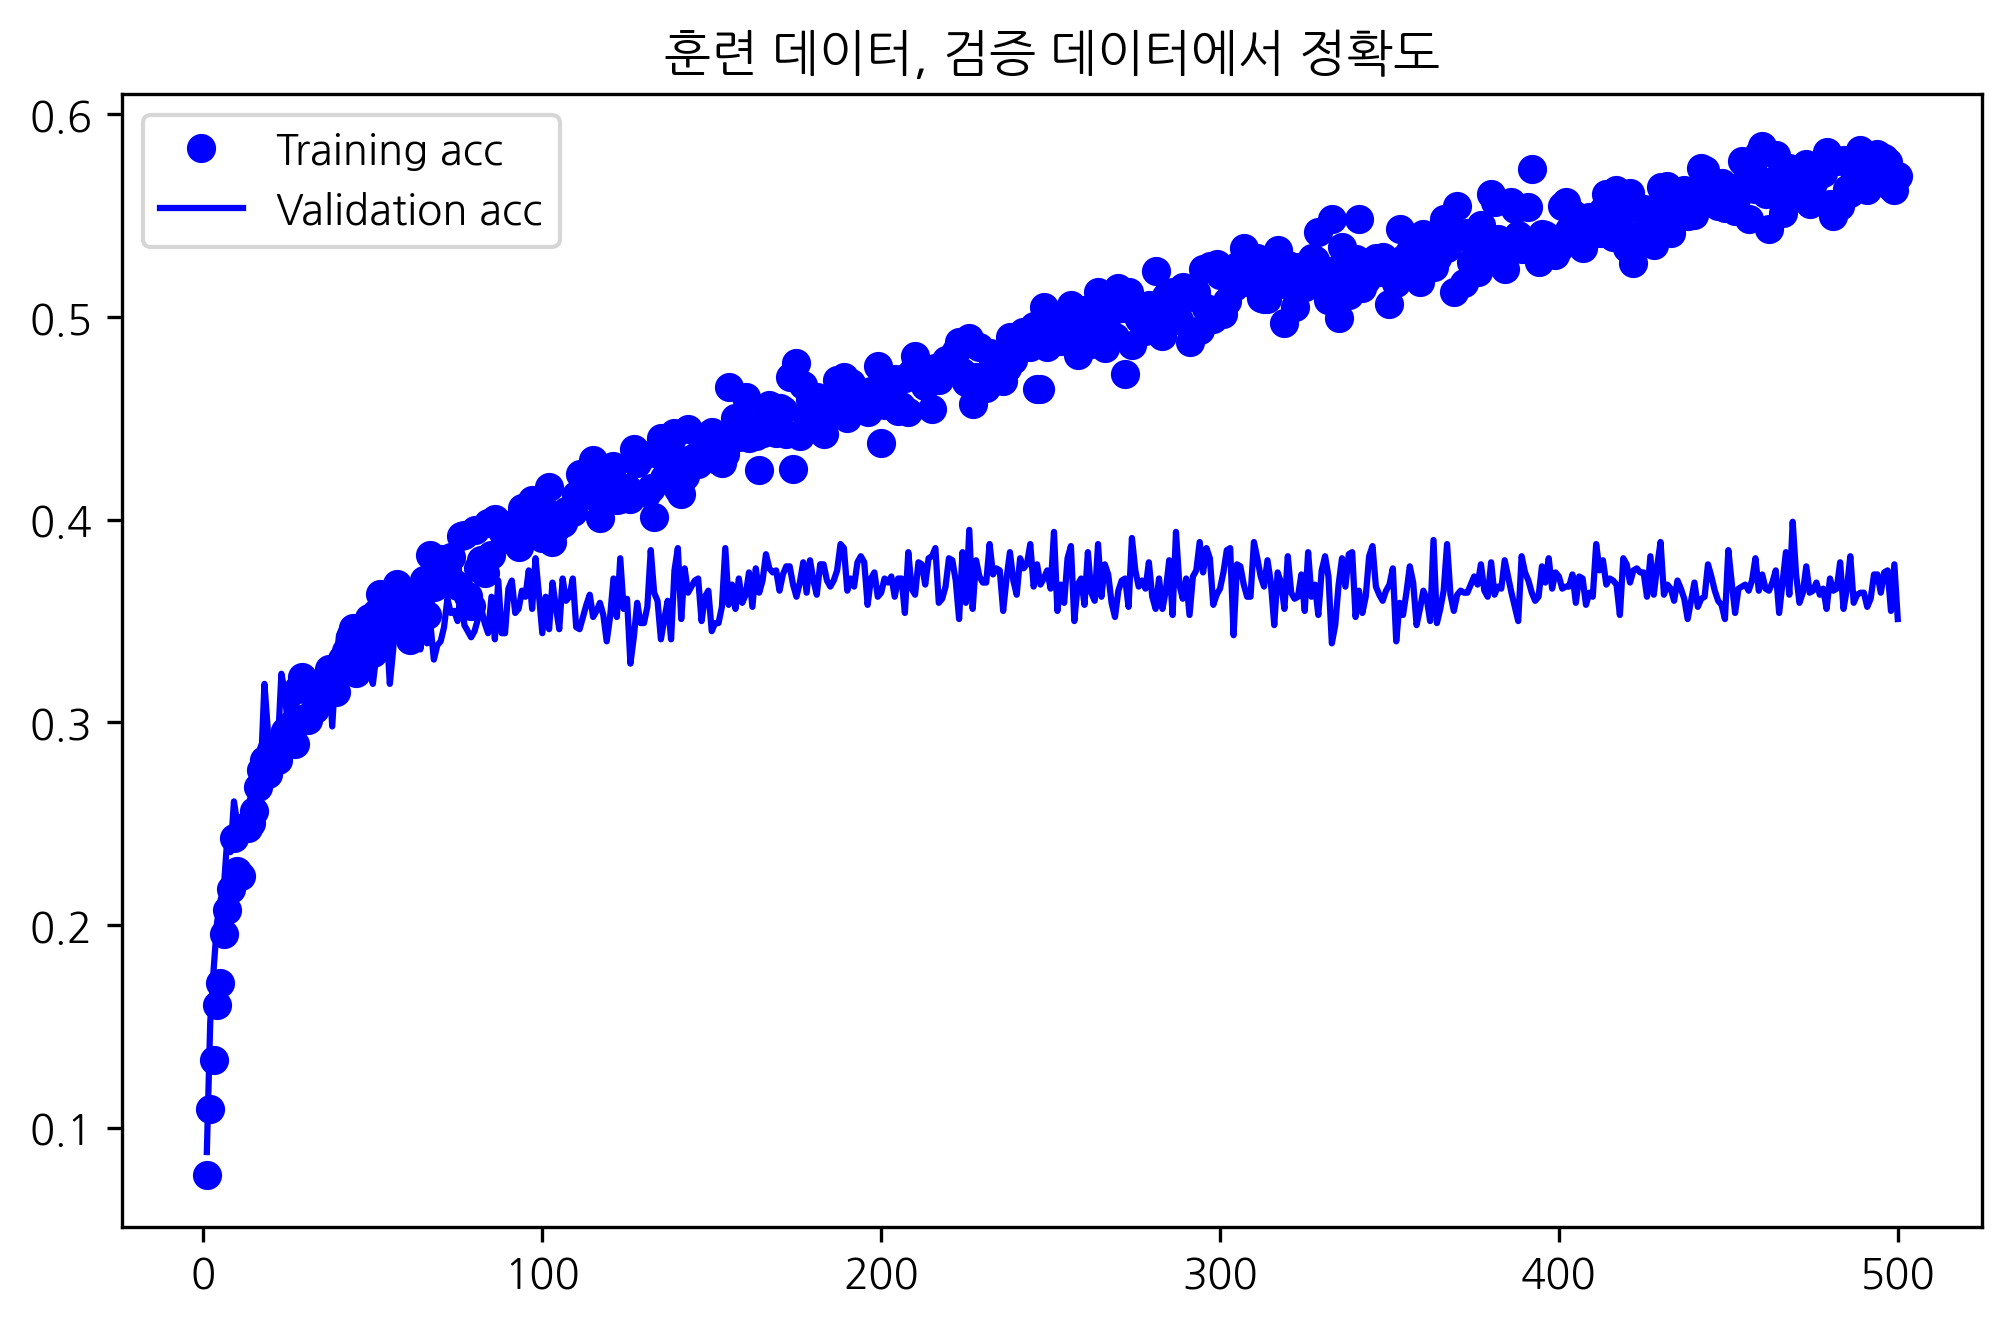

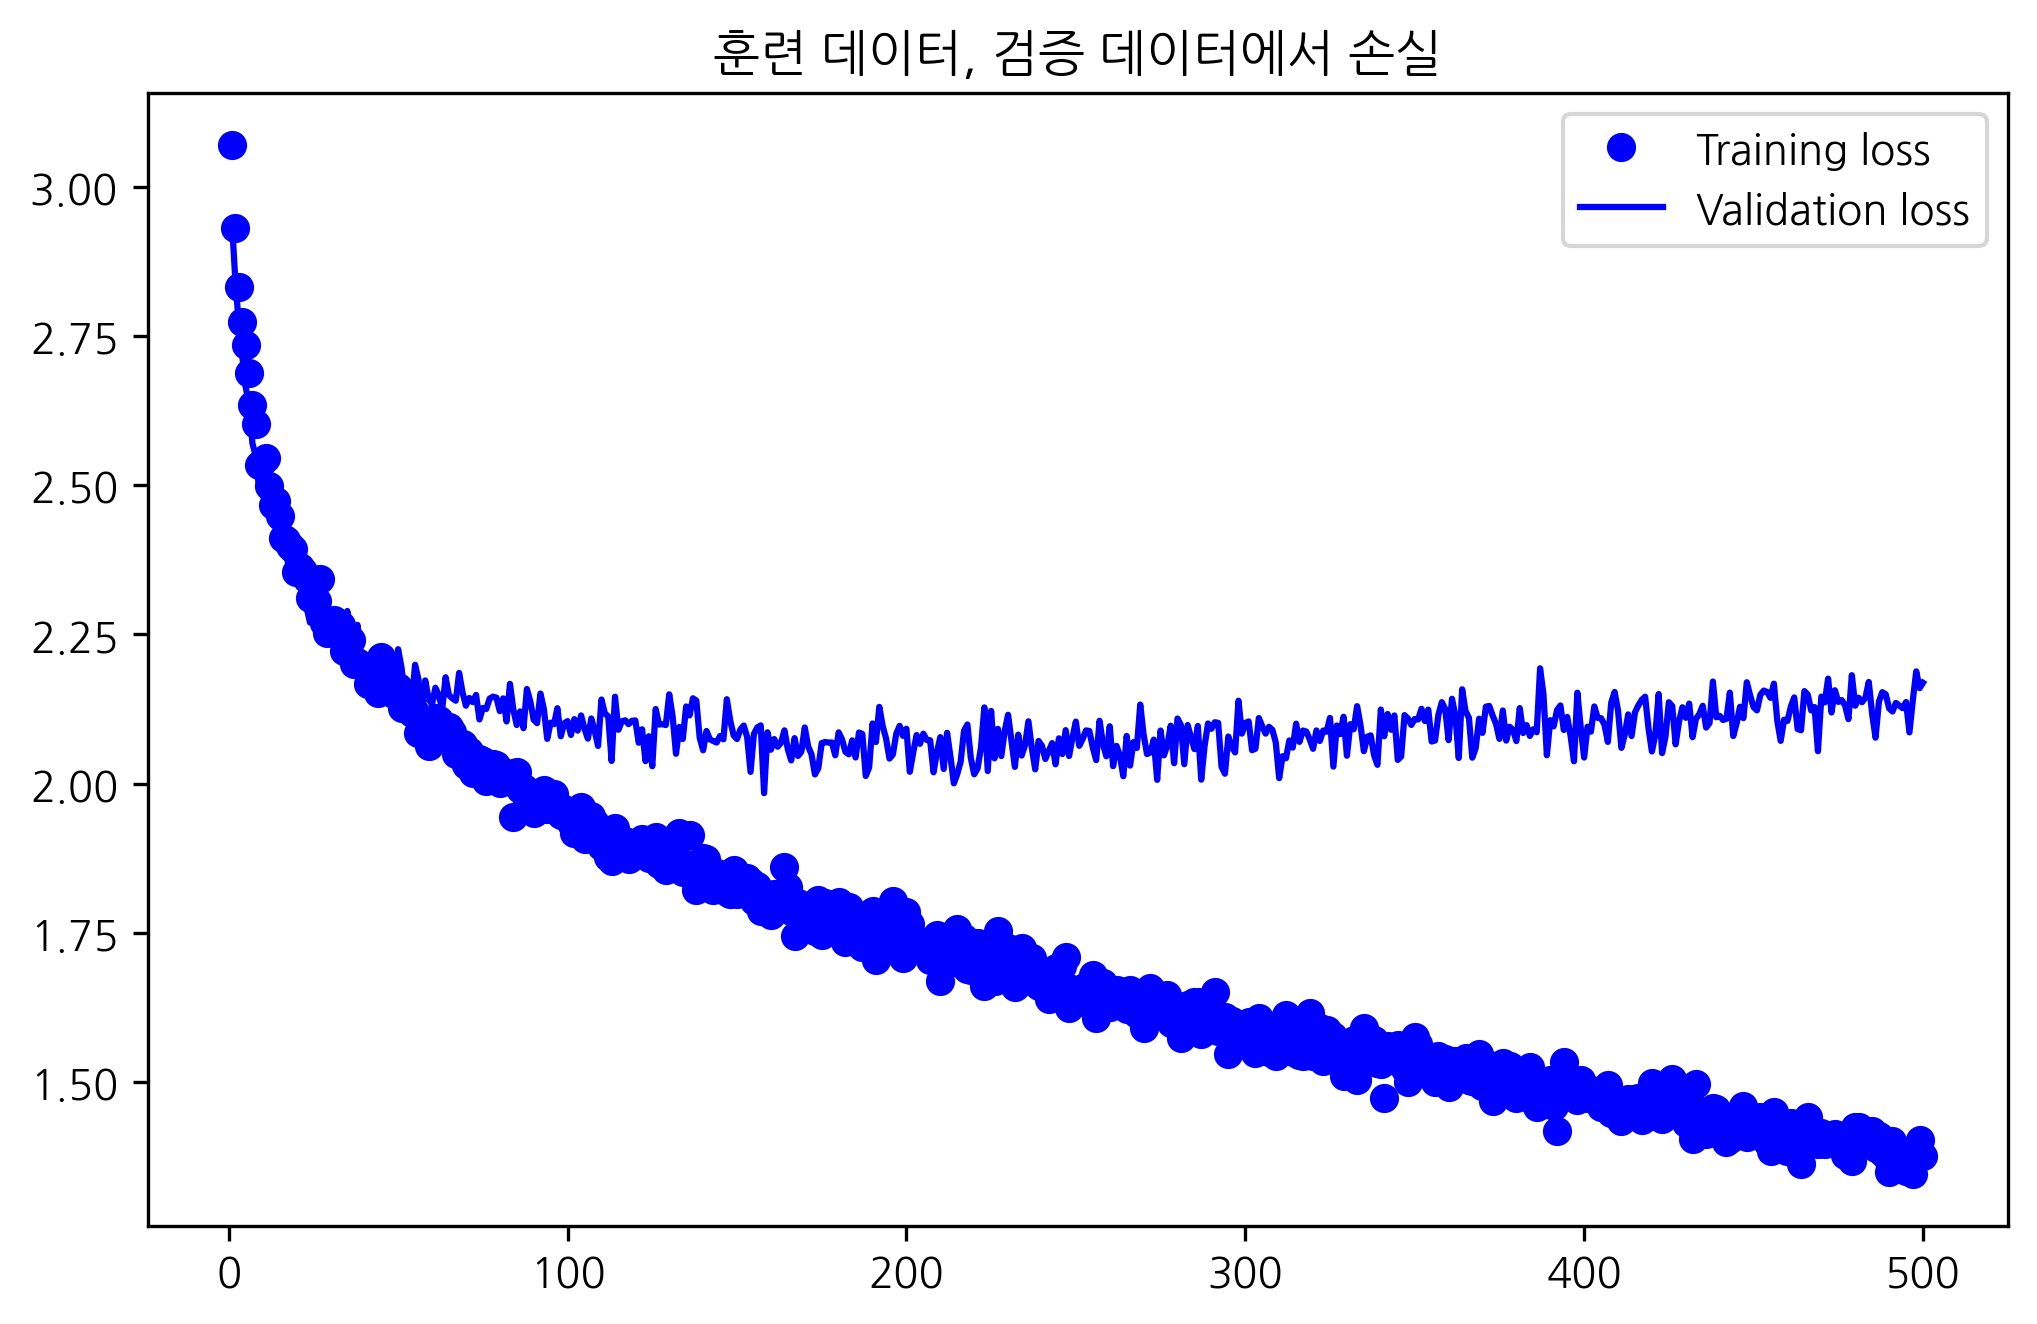

In [4]:
# 결과 시각화 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title(f'훈련 데이터, 검증 데이터에서 정확도')
plt.legend()

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title(f'훈련 데이터, 검증 데이터에서 손실')
plt.legend()

plt.show()

In [8]:
# 미세조정 
# 상위층 동결 해제 (block5)
conv_base.trainable = True 

set_trainable = False 
for layer in conv_base.layers : 
    if layer.name == 'block5_conv1' : 
        set_trainable = True 
    if set_trainable : 
        layer.trainable = True 
    else : 
        layer.trainable = False 

In [9]:
# 미세조정 

# 컴파일
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.rmsprop_v2.RMSprop(lr=1e-6), # 학습률 낮춘다.
    metrics = ['acc']
)
# 훈련
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, 
    epochs=200, 
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Epoch 1/200


2022-02-14 23:33:42.068399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-14 23:34:02.409869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 - 28s - loss: 2.9983 - acc: 0.0570 - val_loss: 3.0072 - val_acc: 0.0500 - 28s/epoch - 285ms/step
Epoch 2/200
100/100 - 28s - loss: 3.0015 - acc: 0.0482 - val_loss: 3.0043 - val_acc: 0.0560 - 28s/epoch - 276ms/step
Epoch 3/200
100/100 - 29s - loss: 3.0005 - acc: 0.0550 - val_loss: 3.0048 - val_acc: 0.0470 - 29s/epoch - 285ms/step
Epoch 4/200
100/100 - 27s - loss: 3.0028 - acc: 0.0560 - val_loss: 3.0038 - val_acc: 0.0470 - 27s/epoch - 274ms/step
Epoch 5/200


KeyboardInterrupt: 